In [1]:
!pip install datasets
!pip install transformers
!pip install bertopic
!sudo apt-get install swig
!sudo pip install jamspell
!wget https://github.com/bakwc/JamSpell-models/raw/master/en.tar.gz
!tar -xvf en.tar.gz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 452 kB 5.2 MB/s 
     |████████████████████████████████| 182 kB 52.3 MB/s 
     |████████████████████████████████| 213 kB 58.4 MB/s 
     |████████████████████████████████| 132 kB 69.6 MB/s 
     |████████████████████████████████| 127 kB 79.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.4 MB/s 
     |████████████████████████████████| 7.6 MB 39.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 3.9 MB/s 
     |████████████████████████████████| 662 kB 32.6 MB/s 
     |████████████████████

In [65]:
import pandas as pd
import numpy as np
from datetime import datetime

import re

import jamspell

from transformers import AutoConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DistilBertForSequenceClassification

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer


import nltk
import string
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from collections import defaultdict
from collections import Counter

import altair as alt
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
uberDf = pd.read_csv('uberdf.csv')

In [5]:
uberDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107254 entries, 0 to 107253
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  107254 non-null  object 
 1   id          107248 non-null  object 
 2   date        107250 non-null  object 
 3   username    107250 non-null  object 
 4   content     107245 non-null  object 
 5   location    86196 non-null   object 
 6   retweets    107240 non-null  float64
 7   likes       107240 non-null  float64
dtypes: float64(2), object(6)
memory usage: 6.5+ MB


In [6]:
corrector = jamspell.TSpellCorrector()
corrector.LoadLangModel('en.bin')
lemmatizer= WordNetLemmatizer()
punct = ''.join([i for i in string.punctuation if i not in [',','?','!','.']])

def light_clean(x):
  # Removemos las url.
  x = re.sub(r"http\S+", ' ', x)
  # Removemos las palabras que empiezan por @.
  x = re.sub(r'@[\w]+', '', x)
  # Signos de puntuacion menos. 
  x = x.translate(str.maketrans('', '', punct))
  x = x.replace('#', '')
  # Spell check
  x = corrector.FixFragment(x)
  return x

In [7]:
uberDf['content'] = uberDf['content'].apply(str)
uberDf['corpus'] = uberDf['content'].apply(light_clean)

In [8]:
uberDf[['date', 'hour']] = uberDf.date.str.split(" ", expand=True)

In [17]:
for i in range(len(uberDf)):
  try:
    uberDf['date'][i] = pd.to_datetime(uberDf['date'][i], format="%Y-%m-%d")
  except:
    print(i)

Streaming output truncated to the last 5000 lines.
26472
26473
26474
26475
26476
26477
26478
26479
26480
26481
26482
26483
26484
26485
26486
26487
26488
26489
26490
26491
26492
26493
26494
26495
26496
26497
26498
26499
26500
26501
26502
26503
26504
26505
26506
26507
26508
26509
26510
26511
26512
26513
26514
26515
26516
26517
26518
26519
26520
26521
26522
26523
26524
26525
26526
26527
26528
26529
26530
26531
26532
26533
26534
26535
26536
26537
26538
26539
26540
26541
26542
26543
26544
26545
26546
26547
26548
26549
26550
26551
26552
26553
26554
26555
26556
26557
26558
26559
26560
26561
26562
26563
26564
26565
26566
26567
26568
26569
26570
26571
26572
26573
26574
26575
26576
26577
26578
26579
26580
26581
26582
26583
26584
26585
26586
26587
26588
26589
26590
26591
26592
26593
26594
26595
26596
26597
26598
26599
26600
26601
26602
26603
26604
26605
26606
26607
26608
26609
26610
26611
26612
26613
26614
26615
26616
26617
26618
26619
26620
26621
26622
26623
26624
26625
26626
26627
26628
26629
2

KeyboardInterrupt: ignored

In [10]:
uberDf['date'][25638]

'0'

In [11]:
# Modelo a utilizar
MODEL = f"siberett/roberta-sentiment-analysis-finetune"

In [12]:
# Iniciamos el tokenizador
tokenizer = AutoTokenizer.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [13]:
# Iniciamos el modelo.
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/964 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [14]:
import operator
from scipy.special import softmax

def polarity_predict(example):
  # vectorizamos el texto
  encoded_text = tokenizer(example, return_tensors='pt')
  # aplicamos el modelo
  output = model(**encoded_text)
  # Cogemos los scores de las labels
  scores = output[0][0].detach().numpy()
  # Normalizamos los scores
  scores = softmax(scores)
  # creamos un diccionario con las label y sus scores
  scores_dict = {
      '0' : scores[0],
      '1' : scores[1],
      '2' : scores[2]
  }
  # Obtenemos la label con mayor score
  final_label = max(scores_dict.items(), key=operator.itemgetter(1))[0]
  
  return final_label

In [15]:
uberDf['label'] = uberDf['corpus'].apply(polarity_predict)

In [45]:
uberDf = uberDf.drop(uberDf[uberDf['date'] == '0'].index)
uberDf['date'] = pd.to_datetime(uberDf['date'], format="%Y-%m-%d")

In [46]:
split_date = datetime(2017,2,19)
preDateDf = uberDf.loc[uberDf['date'] <= split_date]
postDateDf = uberDf.loc[uberDf['date'] > split_date]
(len(preDateDf), len(postDateDf))

(68654, 38591)

In [47]:
countsPre = preDateDf['label'].value_counts(normalize=True).reset_index()
countsPre.columns = ['target', 'ratio']

alt.Chart(countsPre).mark_bar().encode(
    x=alt.X('target:N', title='Categorías'),
    y=alt.Y('ratio:Q', scale=alt.Scale(domain=(0, 1)), title='Ratio sobre total'),
    tooltip=['target', 'ratio']
).properties(width=600, height=200)

alt.Chart(...)

In [48]:
countsPost = postDateDf['label'].value_counts(normalize=True).reset_index()
countsPost.columns = ['target', 'ratio']

alt.Chart(countsPost).mark_bar().encode(
    x=alt.X('target:N', title='Categorías'),
    y=alt.Y('ratio:Q', scale=alt.Scale(domain=(0, 1)), title='Ratio sobre total'),
    tooltip=['target', 'ratio']
).properties(width=600, height=200)

alt.Chart(...)

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

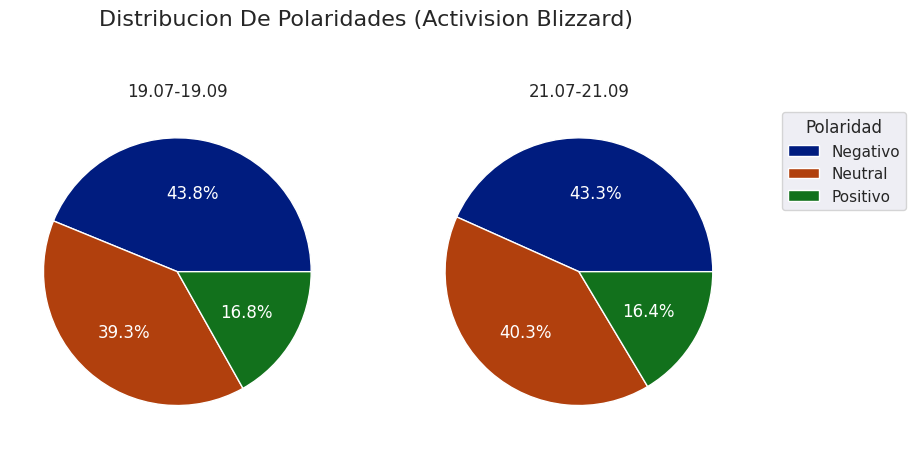

In [50]:
palette_color = sns.color_palette('dark')

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(9.5, 5.5)
fig.set_dpi(100)

fig.suptitle('Distribucion De Polaridades (Activision Blizzard)', fontsize=16)




axs[0].pie(countsPre['ratio'], labels=['Negativo', 'Neutral', 'Positivo'], autopct='%1.1f%%', textprops=dict(color="w"), colors=palette_color)
axs[0].set_title("19.07-19.09")

axs[1].pie(countsPost['ratio'], labels=['Negativo', 'Neutral', 'Positivo'], autopct='%1.1f%%', textprops=dict(color="w"), colors=palette_color)
axs[1].set_title("21.07-21.09")

axs[1].legend(title='Polaridad', loc="upper right", bbox_to_anchor=(1, 0, 0.5, 1))

In [51]:
def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).\
        hist()

In [52]:
word_lensPre = [len(line) for line in preDateDf['content'].str.split()]
print('Media de numero de palabras por tweet antes: ', sum(word_lensPre)/len(preDateDf['content']))

print('Media de numero de tweets diarios: ', len(preDateDf['content'])/preDateDf['date'].nunique())

Media de numero de palabras por tweet antes:  15.954423631543683
Media de numero de tweets diarios:  2214.6451612903224


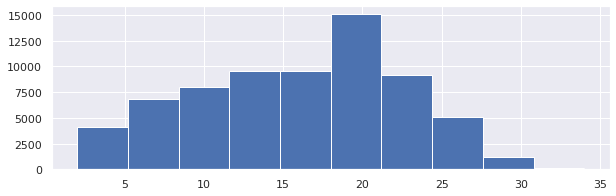

In [53]:
# Antes del incidente
plot_word_number_histogram(preDateDf['content'])

In [54]:
word_lensPost = [len(line) for line in postDateDf['content'].str.split()]
print('Media de numero de palabras por tweet despues: ', sum(word_lensPost)/len(postDateDf['content']))
print('Media de numero de tweets diarios: ', len(postDateDf['content'])/postDateDf['date'].nunique())

Media de numero de palabras por tweet despues:  17.14892073281335
Media de numero de tweets diarios:  1378.25


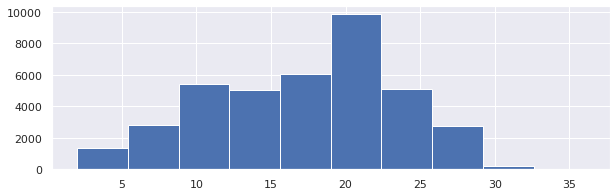

In [55]:
# Despues del incidende. Se aprecia un aumento en el numero de palabras por tweet
plot_word_number_histogram(postDateDf['content'])

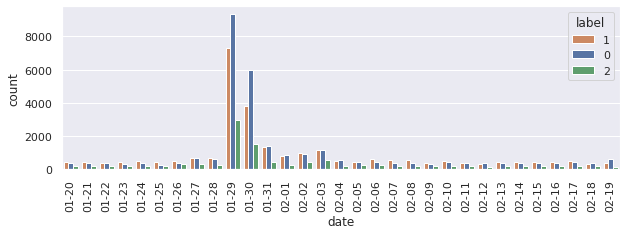

In [56]:
sns.set(rc={"figure.figsize":(10, 3)})
g = sns.countplot(data=preDateDf.sort_values('date'), x="date", hue="label", palette=["C1", "C0", "C2"])
x_dates = preDateDf['date'].dt.strftime('%m-%d').sort_values().unique()
g.set_xticklabels(x_dates)
g.tick_params(axis='x', rotation=90)

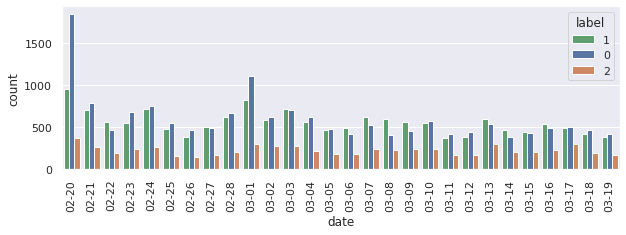

In [57]:
sns.set(rc={"figure.figsize":(10, 3)})
g = sns.countplot(data=postDateDf.sort_values('date'), x="date", hue="label", palette=["C2", "C0", "C1"])
x_dates = postDateDf['date'].dt.strftime('%m-%d').sort_values().unique()
g.set_xticklabels(x_dates)
g.tick_params(axis='x', rotation=90)

In [77]:
from string import digits

def clean(x):
  x = x.lower()
  x = x.translate(str.maketrans('', '', digits))
  # Removemos palabras con menos de dos caracteres.
  x = ' '.join([w for w in x.split() if len(w)>3])
  return x

In [78]:
corpusPre = preDateDf.corpus.apply(clean)
corpusPost = postDateDf.corpus.apply(clean)

In [79]:
corpusPre = corpusPre.apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
corpusPost = corpusPost.apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [80]:
lemmatizer= WordNetLemmatizer()

textsplit = [line.split() for line in corpusPre]
corpusPre = [[lemmatizer.lemmatize(word) for word in line if word not in stopwords.words('english')] for line in textsplit]

corpusPre = [word for i in corpusPre for word in i]

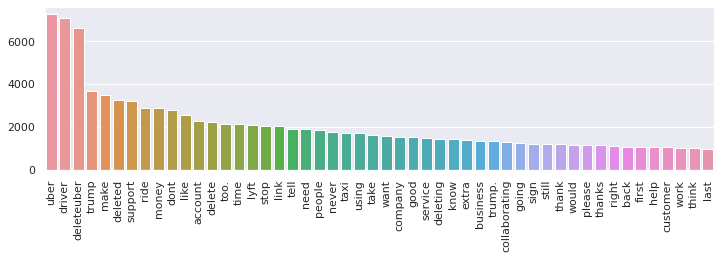

In [81]:
counter=Counter(corpusPre)
most=counter.most_common()

x, y= [], []
for word,count in most[:50]:
        x.append(word)
        y.append(count)

sns.set(rc={"figure.figsize":(12, 3)})
g = sns.barplot(x=x,y=y)
g.tick_params(axis='x', rotation=90)

In [113]:
def _get_top_ngram(corpus, n=None):
  vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:20]

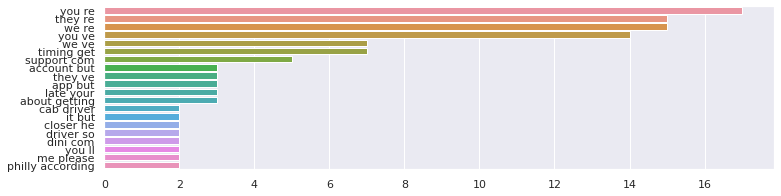

In [115]:
top_n_bigrams=_get_top_ngram(corpusPre,2)[:20]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

In [84]:
lemmatizer= WordNetLemmatizer()

textsplit = [line.split() for line in corpusPost]
corpusPost = [[lemmatizer.lemmatize(word) for word in line if word not in stopwords.words('english')] for line in textsplit]

corpusPost = [word for i in corpusPost for word in i]

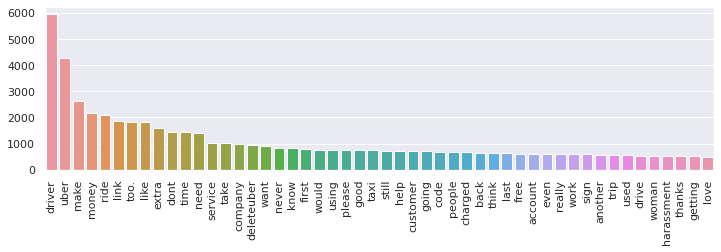

In [96]:
stop=set(stopwords.words('english') + ['we', 'you', 'they', 'dont,' 'its', 're', 've'])
counter=Counter(corpusPost)
most=counter.most_common()

x, y= [], []
for word,count in most[:50]:
    if (word not in stop):
        x.append(word)
        y.append(count)

sns.set(rc={"figure.figsize":(12, 3)})
g = sns.barplot(x=x,y=y)
g.tick_params(axis='x', rotation=90)

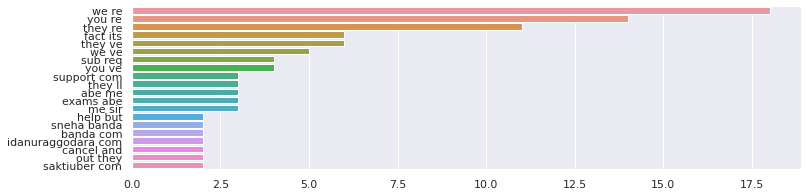

In [116]:
top_n_bigrams=_get_top_ngram(corpusPost,2)[:20]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

In [88]:
vectorizer_model = CountVectorizer(ngram_range=(1,2), stop_words='english')

In [89]:
model = BERTopic(vectorizer_model=vectorizer_model, language='english', calculate_probabilities=True, verbose=True)

In [90]:
temp1 = [i for i in preDateDf['corpus']]
topics, probs = model.fit_transform(temp1)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/2146 [00:00<?, ?it/s]

2022-12-31 15:23:29,586 - BERTopic - Transformed documents to Embeddings
2022-12-31 15:25:21,860 - BERTopic - Reduced dimensionality
2022-12-31 16:29:15,732 - BERTopic - Clustered reduced embeddings


In [91]:
for i in range(15):
  print(f'topic: {i}', model.get_topic(i), '\n')

topic: 0 [('amp', 0.011315714143299857), ('deleted amp', 0.0037460123232985684), ('account amp', 0.0036596672188854815), ('app amp', 0.003164023788796119), ('deleteuber amp', 0.0030526878874379423), ('amp driver', 0.0023162369942282958), ('amp amp', 0.002125301464680812), ('amp drivers', 0.002119852271534041), ('mitsloanexperts', 0.001959628541367766), ('drivers amp', 0.0019521118443851617)] 

topic: 1 [('deleteuber deleteuber', 0.025620024321009387), ('deleteuber', 0.018044732983094627), ('deleteuber goodbye', 0.01747304916084537), ('hello deleteuber', 0.01658708849356307), ('deleted deleteuber', 0.015872606550091022), ('goodbye', 0.012114286992730369), ('goodbye deleteuber', 0.011833713085186047), ('deleteuber bye', 0.01181873599154828), ('goodbye hello', 0.010385494953788257), ('bye deleteuber', 0.009801954407303498)] 

topic: 2 [('deleted app', 0.02561119231029025), ('app', 0.02336565414756403), ('app deleted', 0.016032539622056363), ('deleting app', 0.014866611685389955), ('delete

In [92]:
temp2 = [i for i in postDateDf['corpus']]
topics, probs = model.fit_transform(temp2)

Batches:   0%|          | 0/1206 [00:00<?, ?it/s]

2022-12-31 16:38:19,035 - BERTopic - Transformed documents to Embeddings
2022-12-31 16:39:06,007 - BERTopic - Reduced dimensionality
2022-12-31 16:47:06,456 - BERTopic - Clustered reduced embeddings


In [93]:
for i in range(15):
  print(f'topic: {i}', model.get_topic(i), '\n')

topic: 0 [('amp', 0.015100446155266983), ('like amp', 0.003556337183095689), ('amp driver', 0.0034059627933585046), ('drivers amp', 0.003137794017903316), ('amp drivers', 0.0031117950352087275), ('amp charged', 0.0029986727629938703), ('driver amp', 0.0022800172886750163), ('deleteuber amp', 0.00224109043638345), ('driver', 0.002117186715252739), ('speakers', 0.001867575363652875)] 

topic: 1 [('drivers', 0.011125600196068355), ('driver', 0.011106700890243609), ('best driver', 0.009013269361021266), ('best', 0.0056715347861390035), ('driver just', 0.005439161491011379), ('driver driver', 0.004836696403366555), ('drive', 0.003893472715060167), ('funny', 0.003758481922112475), ('yall', 0.003597673969434103), ('just', 0.0035464941873166)] 

topic: 2 [('uber', 0.018869728692752132), ('uber uber', 0.01623820519866438), ('love uber', 0.007523080374728963), ('use uber', 0.007274146825410575), ('reasons', 0.005679589762168648), ('reasons use', 0.005525910474865607), ('like uber', 0.00518067663

In [133]:
preDateDf['label'].value_counts()

(11564 - 30079) / (11564 + 30079)

-0.4446125399226761

In [135]:
postDateDf['label'].value_counts()

(6337 - 16710) / (6337 + 16710)

-0.4500802707510739